In [46]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [8]:
demo_df = pd.read_csv("c:/sujan/titanic/train.csv")

In [9]:
demo_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Import the dataset: Import the dataset into your programming environment using a library such as Pandas, NumPy, or TensorFlow.

Data Cleaning: Check the dataset for missing values, inconsistent data, and outliers, and handle them accordingly. This might involve filling in missing values, removing duplicates, or removing outliers.

Data Transformation: Transform the data to make it suitable for analysis. This might involve converting categorical variables to numerical values, scaling or normalizing numerical data, or converting date and time values to a standard format.

Feature Extraction: Extract meaningful features from the data that can be used in the analysis. This might involve feature selection, dimensionality reduction, or creating new features using domain knowledge.

Splitting the dataset: Split the dataset into training, validation, and test sets to evaluate the performance of the machine learning model.

Encoding: Convert categorical variables into numeric variables, One-Hot-Encoding or Label Encoding depending on the data and model.

Scaling: Scale the numerical variables to have zero mean and unit variance.

Handling Outliers: Identify and handle outliers in the dataset. This can be done using statistical techniques or domain knowledge.

Handling Imbalanced Data: If the dataset is imbalanced, balance the dataset by either undersampling, oversampling, or using techniques such as SMOTE.

Data Visualization: Visualize the data to gain insights into the data and to detect patterns.

In [11]:
def impute(data):
    #checking missing values
    percent_missing = data.isnull().sum() * 100 / data.shape[0]
    #dropping columns if missing percentage is more than 30
    for i in range(len(data.columns)):
        if percent_missing[i] >30:
            data.drop(data.columns[i],axis=1,inplace=True)
    #getting numerical and categorical variables
    numerical_columns = [x for x in data.columns if data[x].dtype != 'object']
    data_num = data[numerical_columns]
    
    cat_columns = [x for x in data.columns if x not in numerical_columns]
    data_cat = data[cat_columns]
    
    #Imputing using KNN Imputer for numerical columns
    imputer = KNNImputer(n_neighbors=2)
    imputed_num = imputer.fit_transform(data_num)
    imputed_num = pd.DataFrame(imputed_num)
    imputed_num.columns=data_num.columns
    
    # most frequent imputation for categorical columns
    data_cat_imputed = data_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
    
    #concat the imputed dfs
    imputed_data = pd.concat([imputed_num, data_cat_imputed], axis=1)
    
    #return imputed_data
    return imputed_data

In [12]:
ll = impute(demo_df)


In [13]:
ll.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Embarked
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,"Allen, Mr. William Henry",male,373450,S


In [14]:
def EDA(imputed_data,y):
    #pairplot for all attributes
    sns.pairplot(imputed_data, hue=y)

    #plotting histograms for numerical and barplots for categorical variables
    for col in [x for x in imputed_data.columns]:
        if imputed_data[col].dtype in ['int64', 'float64']:
            sns.histplot(data=imputed_data, x=col, hue=y, kde=True, palette="dark").set(title="Histogram of {}".format(str(col)))
            plt.show()
        else:
            if imputed_data[col].value_counts().count()>10:
                continue
            sns.countplot(x=col, data=imputed_data, hue=y, palette="dark").set(title="Countplot of {}".format(str(col)))
            plt.show()

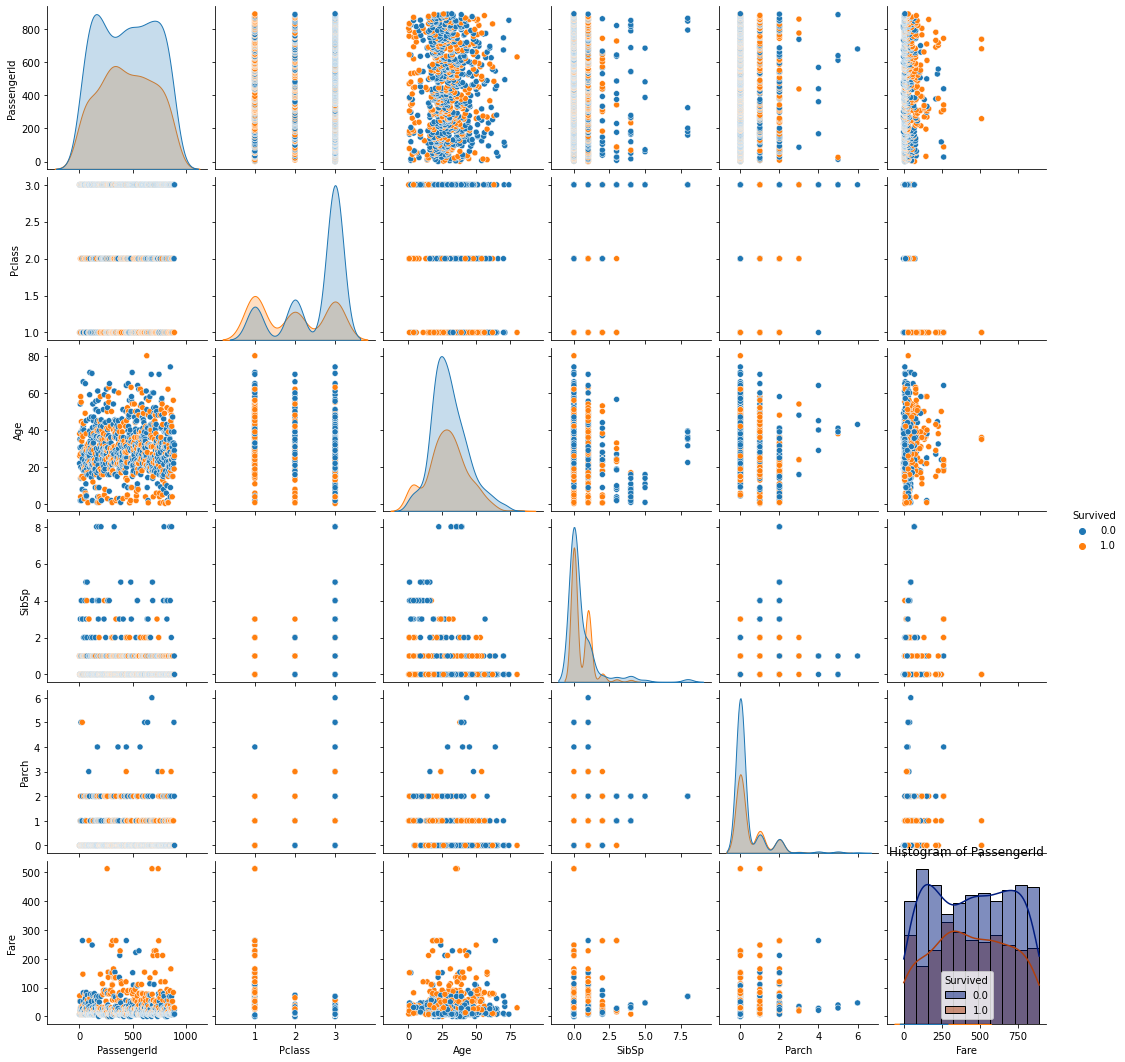

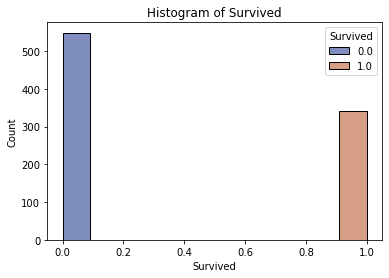

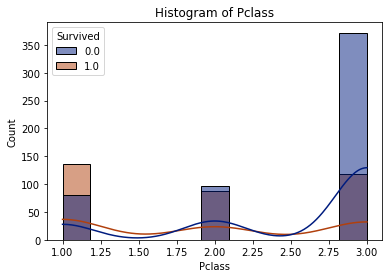

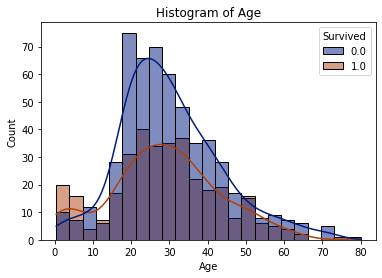

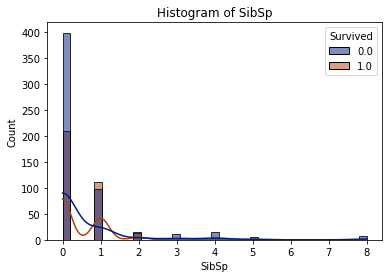

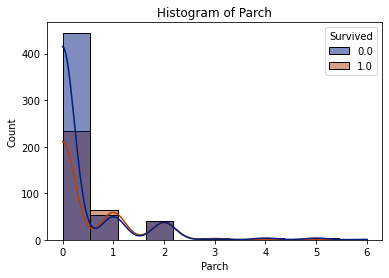

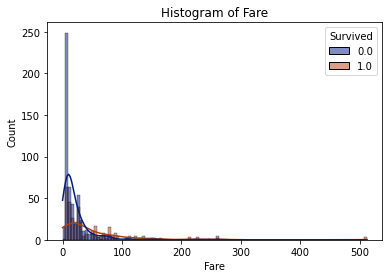

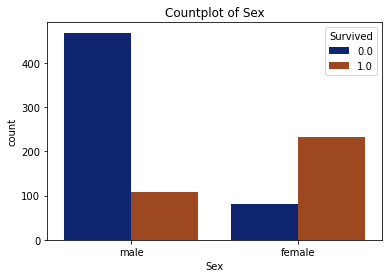

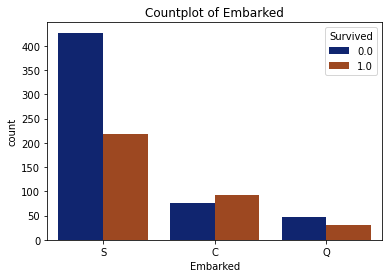

In [15]:
EDA(ll,'Survived')

### 1.some categorical variables can be numerical in inputed data

### 2.robust scalar does not remove outliers, just scales down the gap?

### 3.some cat cols have more than 100 cats what to to do? remove?
 dropping for now, if more than 10

 ### 4. change the algo to exclude y in impute and normalizing function

In [16]:
def normalize_and_encode(imputed_data):
    #normalizing numerical columns using robustscalar
    numerical_columns  = [x for x in imputed_data.columns if imputed_data[x].dtype in ['int64', 'float64']]
    scalar = RobustScaler(quantile_range=(25,75))
    scaled = scalar.fit_transform(imputed_data[numerical_columns])
    scaled = pd.DataFrame(scaled)
    scaled.columns = imputed_data[numerical_columns].columns
    
    #dropping cat columns with more than 10 categories
    cat_cols = [x for x in imputed_data.columns if x not in numerical_columns]
    cat_cols_to_drop = []
    for col in cat_cols:
        if imputed_data[col].value_counts().count()>10:
            cat_cols_to_drop.append(col)
    data_for_enc = imputed_data.drop(numerical_columns,axis=1)
    data_for_enc.drop(cat_cols_to_drop,axis=1,inplace=True)

    #encoding categorical varialbles
    enc_data= pd.get_dummies(data_for_enc, columns=data_for_enc.columns)
    
    encoded_data = pd.concat([scaled, enc_data], axis=1)

    return encoded_data

In [54]:
train = normalize_and_encode(ll)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-1.000000,0.0,0.0,-0.382353,1.0,0.0,-0.312011,0,1,0,0,1
1,-0.997753,1.0,-2.0,0.558824,1.0,0.0,2.461242,1,0,1,0,0
2,-0.995506,1.0,0.0,-0.147059,0.0,0.0,-0.282777,1,0,0,0,1
3,-0.993258,1.0,-2.0,0.382353,1.0,0.0,1.673732,1,0,0,0,1
4,-0.991011,0.0,0.0,0.382353,0.0,0.0,-0.277363,0,1,0,0,1


In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    float64
 1   Survived     891 non-null    float64
 2   Pclass       891 non-null    float64
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    float64
 5   Parch        891 non-null    float64
 6   Fare         891 non-null    float64
 7   Sex_female   891 non-null    uint8  
 8   Sex_male     891 non-null    uint8  
 9   Embarked_C   891 non-null    uint8  
 10  Embarked_Q   891 non-null    uint8  
 11  Embarked_S   891 non-null    uint8  
dtypes: float64(7), uint8(5)
memory usage: 53.2 KB


In [49]:
classifiers = [XGBClassifier(n_jobs=4, random_state=100, categorical_feature=True), 
               LGBMClassifier(is_unbalance=True, n_jobs=4, random_state=100), 
               RandomForestClassifier(random_state=100),
               GradientBoostingClassifier(random_state=100), DecisionTreeClassifier(random_state=100),
               LogisticRegression(random_state=100)]

In [56]:
def training(train_data, y, classifiers):

    y_class = train[[y]]
    train.drop(y, axis=1, inplace=True)
    
    X_train, X_val, y_train, y_val = train_test_split(train, y_class, stratify=y_class, test_size=0.2, random_state=100)

    res = {}

    for clf in classifiers:   
        name = clf.__class__.__name__  
        clf.fit(X_train, y_train)
        
        acc = round(balanced_accuracy_score(y_val, clf.predict(X_val)), 3)
        f1 = round(f1_score(y_true=y_val, y_pred = clf.predict(X_val), average='weighted'), 3)

        print("{} trained with an F1 of : {} and an accuracy of: {}".format(name, f1, acc))

        res[name] = (acc, f1)

    return res

In [57]:
training(train, 'Survived', classifiers=classifiers)

[22:47:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "categorical_feature" } are not used.

XGBClassifier trained with an F1 of : 0.839 and an accuracy of: 0.833
LGBMClassifier trained with an F1 of : 0.833 and an accuracy of: 0.829


c:\Users\sujan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sujan\AppData\Local\Temp/ipykernel_13276/867942880.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier trained with an F1 of : 0.861 and an accuracy of: 0.854
GradientBoostingClassifier trained with an F1 of : 0.833 and an accuracy of: 0.826
DecisionTreeClassifier trained with an F1 of : 0.767 and an accuracy of: 0.76
LogisticRegression trained with an F1 of : 0.8 and an accuracy of: 0.796


c:\Users\sujan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\sujan\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'XGBClassifier': (0.833, 0.839),
 'LGBMClassifier': (0.829, 0.833),
 'RandomForestClassifier': (0.854, 0.861),
 'GradientBoostingClassifier': (0.826, 0.833),
 'DecisionTreeClassifier': (0.76, 0.767),
 'LogisticRegression': (0.796, 0.8)}